<a href="https://colab.research.google.com/github/choikanghoon/Aiffel_study/blob/master/MainQuest/main_Quest03_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 가위바위보

가위바위보 분류기를 만들려고 한다.
1. 목차
- 버전확인
- 구글마운트
- train_datasets 불러오기 (채림님 데이터 사용)
- train 생성
    - X_train 과 y_train을 나누고, 20%를 검증용 데이터 사용
- 1번째 모델 생성
    - 결과
- 2번째 모델 생성(데이터증강, 배치정규화) ( 성능이 좋지 못했음 )
- 회고
- 1번째 test 파일 불러오기 ( 보겸님 데이터 사용 )
- 1번째 test 파일 결과
    - 91.77% 까지 결과 도출 성공
- 2번째 test 파일 불러오기 ( 새로 웹캠으로 촬영 후 test파일 생성 )
- 2번째 test 파일 결과
    - 30% 대의 결과로 의미 없는 결과 확인


## 버전확인

In [1]:
import tensorflow as tf
import numpy as np

print(tf.__version__)
print(np.__version__)

2.12.0
1.23.5


## 구글 마운트

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from PIL import Image
import glob
import os

print("PIL 라이브러리 import 완료!")

PIL 라이브러리 import 완료!


## train_datasets 불러오기

In [4]:
import os
import shutil

def copy_folder(src_dir, dst_dir):
    """
    src_dir 디렉토리를 dst_dir 디렉토리에 복사합니다.

    Args:
        src_dir: 복사할 디렉토리 경로
        dst_dir: 복사할 디렉토리의 대상 경로

    Returns:
        None
    """

    if not os.path.isdir(src_dir):
        raise FileNotFoundError(f"{src_dir} 디렉토리가 존재하지 않습니다.")
    if os.path.isdir(dst_dir):
        raise FileExistsError(f"{dst_dir} 디렉토리가 이미 존재합니다.")

    os.makedirs(dst_dir, exist_ok=True)

    for file in os.listdir(src_dir):
        src_file_path = os.path.join(src_dir, file)
        dst_file_path = os.path.join(dst_dir, file)

        if os.path.isfile(src_file_path):
            shutil.copy2(src_file_path, dst_file_path)
        elif os.path.isdir(src_file_path):
            copy_folder(src_file_path, dst_file_path)


if __name__ == "__main__":
    src_dir = "/content/drive/MyDrive/가위바위보 데이터셋/홍채림 - zip 안해둠/rock_scissor_paper"
    dst_dir = "/content/drive/MyDrive/아이펠과정/Main_Quest03/채림"

    copy_folder(src_dir, dst_dir)

In [44]:
from PIL import Image
import os
import glob

def resize_images(img_path):
    images = glob.glob(img_path + "/*.jpg")

    print(len(images), " images to be resized.")

    # 파일마다 모두 28x28 사이즈로 바꾸어 저장합니다.
    target_size = (28, 28)
    for img in images:
        old_img = Image.open(img)
        new_img = old_img.resize(target_size, Image.ANTIALIAS)
        new_img.save(img, "JPEG")

    print(len(images), " images resized.")

# 가위 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서
scissor_path = "/content/drive/MyDrive/아이펠과정/Main_Quest03/채림/paper"
paper_path = "/content/drive/MyDrive/아이펠과정/Main_Quest03/채림/rock"
rock_path = "/content/drive/MyDrive/아이펠과정/Main_Quest03/채림/scissor"

resize_images(scissor_path)
resize_images(paper_path)
resize_images(rock_path)

1140  images to be resized.


<ipython-input-44-a5d789bdfb43>:14: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  new_img = old_img.resize(target_size, Image.ANTIALIAS)


1140  images resized.
1024  images to be resized.
1024  images resized.
1077  images to be resized.
1077  images resized.


## train 생성

In [75]:
import numpy as np

def load_data(img_path, number_of_data=3241):  # 가위바위보 이미지 개수 총합에 주의하세요.
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=28
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1

    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1

    print("학습데이터(x_train)의 이미지 개수는", idx,"입니다.")
    return imgs, labels

image_dir_path = "/content/drive/MyDrive/아이펠과정/Main_Quest03/채림"
(x_train, y_train)=load_data(image_dir_path)
x_train_norm = x_train/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))

학습데이터(x_train)의 이미지 개수는 3241 입니다.
x_train shape: (3241, 28, 28, 3)
y_train shape: (3241,)


In [76]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(x_train_norm, y_train, test_size=0.2, random_state=42) # 검증데이터 생성 및 랜덤값을 42번으로 고정

## 1번째 모델 생성

In [102]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

n_channel_1=16
n_channel_2=32
n_channel_3=64
n_dense=128
n_train_epoch=15
from tensorflow.keras.callbacks import EarlyStopping # 모델이 향상되지 않을경우 멈추는 기능

model=keras.models.Sequential()
model.add(keras.layers.Conv2D(n_channel_1, (3,3), activation='relu', input_shape=(28,28,3))) # 처음 들어오는 사이즈가 28x28의 3채널을 가졌고 3x3 필터를 사용 relu 함수 사용
model.add(keras.layers.MaxPool2D(2,2)) # 맥스풀링 2X2
model.add(keras.layers.Conv2D(n_channel_2, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Conv2D(n_channel_3, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(n_dense, activation='relu'))

model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(3, activation='softmax'))


model.summary()

# 모델 학습
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

# model.compile(optimizer='adam',
#              loss='sparse_categorical_crossentropy',
#              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

model.fit(X_train, y_train, validation_data=(X_val, y_val),epochs=n_train_epoch) # val_loss, val_accuracy 확인하기




Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_61 (Conv2D)          (None, 26, 26, 16)        448       
                                                                 
 max_pooling2d_61 (MaxPoolin  (None, 13, 13, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_62 (Conv2D)          (None, 11, 11, 32)        4640      
                                                                 
 max_pooling2d_62 (MaxPoolin  (None, 5, 5, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_63 (Conv2D)          (None, 3, 3, 64)          18496     
                                                                 
 max_pooling2d_63 (MaxPoolin  (None, 1, 1, 64)       

### 결과

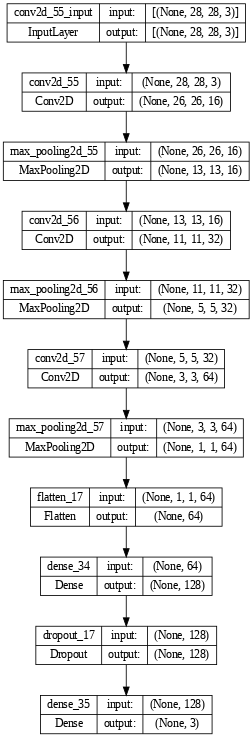

In [95]:
from tensorflow.keras.utils import plot_model  # 모델 구조를 시각화하는 데 사용되는 함수 제공
plot_model(model, show_shapes=True, expand_nested=True, dpi=60)

1차

n_channel_1=32
n_channel_2=64
n_channel_3=128
n_dense=256
n_train_epoch=15
드롭아웃=0.2

0.5393 -> 0.7827 -> 0.8536 -> 0.9153 -> 0.9322 -> 0.9676 -> 0.9630 -> 0.9723 -> 0.9769 -> 0.9846 -> 0.9815 -> 0.9815 -> 0.9908 -> ... -> 0.9861

2차

n_channel_1=16
n_channel_2=32
n_channel_3=64
n_dense=128
n_train_epoch=15
드롭아웃=0.2

0.4299 -> 0.4468 -> 0.8505 -> 0.9137 -> 0.9230 -> 0.9106 -> 0.9615 -> 0.9584 -> 0.9476 -> 0.9199 -> 0.9831 -> 0.9831 -> ... -> 0.9861

3차

n_channel_1=16
n_channel_2=32
n_channel_3=64
n_dense=128
n_train_epoch=15
드롭아웃=0.2
Adam 학습률 0.001

0.6086 -> 0.7011 -> 0.7982 -> 0.8059 -> 0.9368 -> 0.9353 -> 0.9553 -> 0.9723 -> 0.9707 -> 0.9815 -> 0.9800 -> 0.9831 -> 0.9892 -> ... -> 0.9753

대부분 과적합이 일어나는 것인지, 정확도가 오르락 내리락 하는 구간이 있음 4차부터는 ealry_stoping을 사용해야 할 듯

4차

n_channel_1=32
n_channel_2=64
n_channel_3=128
n_dense=256
n_train_epoch=15
드롭아웃=0.2
ealry_stoping = 2
일때

0.4961 -> 0.7920 -> 0.7720 -> 0.9414 -> 0.9307 -> 0.9337 -> 0.9676 -> 0.9599 -> 0.9784 -> 0.9784 -> 0.9815 -> 0.9599 -> 0.9753 -> ... -> 0.9861

5차

n_channel_1=16
n_channel_2=32
n_channel_3=64
n_dense=128
n_train_epoch=15
드롭아웃=0.2

0.6179 -> 0.7427 -> 0.8105 -> 0.8752 -> 0.8829 -> 0.8752 -> 0.9399 -> 0.9337 -> 0.9553 -> 0.9692 -> 0.9569 -> 0.9738 -> 0.9846 -> ... -> 0.9861

6차

n_channel_1=16
n_channel_2=32
n_channel_3=64
n_dense=128
n_train_epoch=15
드롭아웃=0.2
Adam 학습률 0.001

0.5331 -> 0.7504 -> 0.8120 -> 0.8983 -> 0.9414 -> 0.9322 -> 0.9461 -> 0.9676 -> 0.9384 -> 0.9800 -> 0.9630 -> 0.9723 -> 0.9861 -> ... -> 0.9846

## 2번째 모델 생성

데이터 증강 + 배치정규화 까지 했지만, 결과는 더 좋지 않게 나온 것 같다.

In [96]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout # 배치 정규화 추가
from tensorflow.keras.preprocessing.image import ImageDataGenerator # 데이터 증강

n_channel_1=32
n_channel_2=64
n_channel_3=128
n_dense=256
n_train_epoch=15
from tensorflow.keras.callbacks import EarlyStopping # 모델이 향상되지 않을경우 멈추는 기능

model = keras.models.Sequential()
model.add(keras.layers.Conv2D(n_channel_1, (3,3), activation='relu', input_shape=(28,28,3))) # 처음 들어오는 사이즈가 28x28의 3채널을 가졌고 3x3 필터를 사용 relu 함수 사용
model.add(keras.layers.MaxPool2D(2,2)) # 맥스풀링 2X2
model.add(keras.layers.Conv2D(n_channel_2, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Conv2D(n_channel_3, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(n_dense, activation='relu'))

model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(3, activation='softmax'))


model.summary()

# 모델 학습
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
early_stopping = EarlyStopping(monitor='val_loss', patience=1, restore_best_weights=True)

# 모델 훈련
model.fit(X_train, y_train, validation_data=(X_val, y_val),epochs=n_train_epoch) # val_loss, val_accuracy 확인하기

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_58 (Conv2D)          (None, 26, 26, 32)        896       
                                                                 
 max_pooling2d_58 (MaxPoolin  (None, 13, 13, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_59 (Conv2D)          (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_59 (MaxPoolin  (None, 5, 5, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_60 (Conv2D)          (None, 3, 3, 128)         73856     
                                                                 
 max_pooling2d_60 (MaxPoolin  (None, 1, 1, 128)      

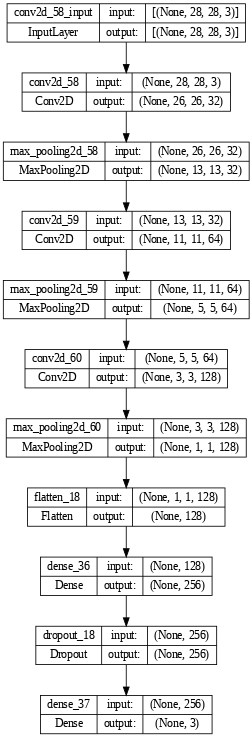

In [97]:
from tensorflow.keras.utils import plot_model  # 모델 구조를 시각화하는 데 사용되는 함수 제공
plot_model(model, show_shapes=True, expand_nested=True, dpi=60)

## 1번째 test 파일 불러오기

In [21]:
import os
import shutil

def copy_folder(src_dir, dst_dir):
    """
    src_dir 디렉토리를 dst_dir 디렉토리에 복사합니다.

    Args:
        src_dir: 복사할 디렉토리 경로
        dst_dir: 복사할 디렉토리의 대상 경로

    Returns:
        None
    """

    if not os.path.isdir(src_dir):
        raise FileNotFoundError(f"{src_dir} 디렉토리가 존재하지 않습니다.")
    if os.path.isdir(dst_dir):
        raise FileExistsError(f"{dst_dir} 디렉토리가 이미 존재합니다.")

    os.makedirs(dst_dir, exist_ok=True)

    for file in os.listdir(src_dir):
        src_file_path = os.path.join(src_dir, file)
        dst_file_path = os.path.join(dst_dir, file)

        if os.path.isfile(src_file_path):
            shutil.copy2(src_file_path, dst_file_path)
        elif os.path.isdir(src_file_path):
            copy_folder(src_file_path, dst_file_path)


if __name__ == "__main__":
    src_dir = "/content/drive/MyDrive/가위바위보 데이터셋/조보겸 (O)/rock_scissor_paper"
    dst_dir = "/content/drive/MyDrive/아이펠과정/Main_Quest03/보겸"

    copy_folder(src_dir, dst_dir)

FileExistsError: ignored

In [12]:
from PIL import Image
import os
import glob

def resize_images(img_path):
    images = glob.glob(img_path + "/*.jpg")

    print(len(images), " images to be resized.")

    # 파일마다 모두 28x28 사이즈로 바꾸어 저장합니다.
    target_size = (28, 28)
    for img in images:
        old_img = Image.open(img)
        new_img = old_img.resize(target_size, Image.ANTIALIAS)
        new_img.save(img, "JPEG")

    print(len(images), " images resized.")

# 가위 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서
scissor_path = "/content/drive/MyDrive/아이펠과정/Main_Quest03/보겸/paper"
paper_path = "/content/drive/MyDrive/아이펠과정/Main_Quest03/보겸/rock"
rock_path = "/content/drive/MyDrive/아이펠과정/Main_Quest03/보겸/scissor"

resize_images(scissor_path)
resize_images(paper_path)
resize_images(rock_path)

100  images to be resized.


<ipython-input-12-d615607c81f6>:14: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  new_img = old_img.resize(target_size, Image.ANTIALIAS)


100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.


In [89]:
import numpy as np

def load_data(img_path, number_of_data=304):  # 가위바위보 이미지 개수 총합에 주의하세요.
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=28
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1

    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1

    print("학습데이터(x_train)의 이미지 개수는", idx,"입니다.")
    return imgs, labels

image_dir_path = "/content/drive/MyDrive/아이펠과정/Main_Quest03/보겸"
(x_test, y_test)=load_data(image_dir_path)
x_test_norm = x_test/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_test shape: {}".format(x_test.shape))
print("y_test shape: {}".format(y_test.shape))

학습데이터(x_train)의 이미지 개수는 300 입니다.
x_train shape: (304, 28, 28, 3)
y_train shape: (304,)


## 1번째 test 예측 결과

In [90]:
test_loss, test_accuracy = model.evaluate(x_test_norm, y_test, verbose=2)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

10/10 - 0s - loss: 0.3957 - accuracy: 0.8553 - 118ms/epoch - 12ms/step
test_loss: 0.39571887254714966 
test_accuracy: 0.8552631735801697


### 결과

1차

10/10 - 0s - loss: 0.3709 - accuracy: 0.8849 - 139ms/epoch - 14ms/step
test_loss: 0.3708781599998474
test_accuracy: 0.8848684430122375

2차

10/10 - 0s - loss: 0.5478 - accuracy: 0.8355 - 297ms/epoch - 30ms/step
test_loss: 0.5477541089057922
test_accuracy: 0.8355262875556946

3차

10/10 - 0s - loss: 0.2477 - accuracy: 0.9178 - 93ms/epoch - 9ms/step
test_loss: 0.24772071838378906
test_accuracy: 0.917763173580169

4차

10/10 - 0s - loss: 0.5625 - accuracy: 0.8454 - 120ms/epoch - 12ms/step
test_loss: 0.562507152557373
test_accuracy: 0.8453947305679321

5차

10/10 - 0s - loss: 0.2590 - accuracy: 0.8816 - 98ms/epoch - 10ms/step
test_loss: 0.25900816917419434
test_accuracy: 0.8815789222717285

6차

10/10 - 0s - loss: 0.2668 - accuracy: 0.8980 - 93ms/epoch - 9ms/step
test_loss: 0.26684921979904175
test_accuracy: 0.8980262875556946

## 2번째 test 파일 불러오기

In [62]:
from PIL import Image
import os
import glob

def resize_images(img_path):
    images = glob.glob(img_path + "/*.jpg")

    print(len(images), " images to be resized.")

    # 파일마다 모두 28x28 사이즈로 바꾸어 저장합니다.
    target_size = (28, 28)
    for img in images:
        old_img = Image.open(img)
        new_img = old_img.resize(target_size, Image.ANTIALIAS)
        new_img.save(img, "JPEG")

    print(len(images), " images resized.")

# 가위 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서
scissor_path = "/content/drive/MyDrive/아이펠과정/Main_Quest03/test/paper"
paper_path = "/content/drive/MyDrive/아이펠과정/Main_Quest03/test/rock"
rock_path = "/content/drive/MyDrive/아이펠과정/Main_Quest03/test/scissor"

resize_images(scissor_path)
resize_images(paper_path)
resize_images(rock_path)

101  images to be resized.


<ipython-input-62-4f72ba462285>:14: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  new_img = old_img.resize(target_size, Image.ANTIALIAS)


101  images resized.
100  images to be resized.
100  images resized.
112  images to be resized.
112  images resized.


In [91]:
import numpy as np

def load_data(img_path, number_of_data=313):  # 가위바위보 이미지 개수 총합에 주의하세요.
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=28
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1

    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1

    print("학습데이터(x_train)의 이미지 개수는", idx,"입니다.")
    return imgs, labels

image_dir_path = "/content/drive/MyDrive/아이펠과정/Main_Quest03/test"
(x_test, y_test)=load_data(image_dir_path)
x_test_norm = x_test/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_test shape: {}".format(x_test.shape))
print("y_test shape: {}".format(y_test.shape))

학습데이터(x_train)의 이미지 개수는 313 입니다.
x_train shape: (313, 28, 28, 3)
y_train shape: (313,)


## 2번째 test 예측 결과

In [92]:
test_loss, test_accuracy = model.evaluate(x_test_norm, y_test, verbose=2)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

10/10 - 0s - loss: 3.9595 - accuracy: 0.3035 - 122ms/epoch - 12ms/step
test_loss: 3.959491491317749 
test_accuracy: 0.30351439118385315


## 3번째 test 파일 불러오기

In [98]:
from PIL import Image
import os
import glob

def resize_images(img_path):
    images = glob.glob(img_path + "/*.jpg")

    print(len(images), " images to be resized.")

    # 파일마다 모두 28x28 사이즈로 바꾸어 저장합니다.
    target_size = (28, 28)
    for img in images:
        old_img = Image.open(img)
        new_img = old_img.resize(target_size, Image.ANTIALIAS)
        new_img.save(img, "JPEG")

    print(len(images), " images resized.")

# 가위 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서
scissor_path = "/content/drive/MyDrive/아이펠과정/Main_Quest03/이선재/paper"
paper_path = "/content/drive/MyDrive/아이펠과정/Main_Quest03/이선재/rock"
rock_path = "/content/drive/MyDrive/아이펠과정/Main_Quest03/이선재/scissor"

resize_images(scissor_path)
resize_images(paper_path)
resize_images(rock_path)

267  images to be resized.


<ipython-input-98-e7c967160c98>:14: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  new_img = old_img.resize(target_size, Image.ANTIALIAS)


267  images resized.
243  images to be resized.
243  images resized.
243  images to be resized.
243  images resized.


In [103]:
import numpy as np

def load_data(img_path, number_of_data=753):  # 가위바위보 이미지 개수 총합에 주의하세요.
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=28
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1

    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1

    print("학습데이터(x_train)의 이미지 개수는", idx,"입니다.")
    return imgs, labels

image_dir_path = "/content/drive/MyDrive/아이펠과정/Main_Quest03/이선재"
(x_test, y_test)=load_data(image_dir_path)
x_test_norm = x_test/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_test shape: {}".format(x_test.shape))
print("y_test shape: {}".format(y_test.shape))

학습데이터(x_train)의 이미지 개수는 753 입니다.
x_test shape: (753, 28, 28, 3)
y_test shape: (753,)


## 3번째 test 예측 결과

In [105]:
test_loss, test_accuracy = model.evaluate(x_test_norm, y_test, verbose=2)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

24/24 - 0s - loss: 0.0058 - accuracy: 0.9987 - 338ms/epoch - 14ms/step
test_loss: 0.005779704079031944 
test_accuracy: 0.9986720085144043


# 회고

채림님이 데이터를 3200개나 모았다는 이야기를 듣고 train 셋으로 사용 하였으며,
보겸님의 데이터를 test로 사용하였다. 그결과 80%이상의 정확도가 나타났고 그중, 학습률을 0.001 을 사용하였을때 91.77%라는 높은 정확도를 뽑아낼 수 있었다.
하지만 예측값이 고정적이 아닌 랜덤한 요소가 있는 것 같다.
마지막 6차에서 stoping을 설정하였지만, 결국 에포크가 15번 다 돌았는데

결과가 90%를 미치지 못하였다.

# 회고

test 데이터를 다른 것을 사용해도 높게 나올 수 있을까 라는 생각으로 진행을 하였다. 결과는 처참하게 30%대가 나왔다....
주말에 부모님과의 약속 등 다양한 것이 있기에, 마무리를 짓지 못한 것이 매우 아쉽다.

# 회고

선재님의 파일도 test파일로 실행 하였는데, 아마 train에 있는 데이터와 동일하기 때문에
매우 결과가 높게 나온 것으로 생각된다.
왜.. 처음 들어오는 test 셋이 들어오면 정확도가 심하게 떨어지는지 이유를 모르겠다.

# 회고
- K
    - 데이터 셋의 양을 높여서 재차 코딩
- P
    - 데이터셋과 관련된 test 데이터를 제외한 새로운 test에 대한 결과가 좋지 못함
- T
    - 데이터 증강하는 법을 찾아 추가를 하였음

하지만, 결과는 더 좋지않은 결과를 초래 하였음, try 해본점은 좋았으나, 해결되지 않았음 새로 다시 처음부터 생각을 해야 할 듯